In [1]:
# | default_exp framedimensions
# | export
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class FramingDimensions:
    def __init__(self, base_model, dimensions, pole_names):
        self.encoder = SentenceTransformer(base_model)
        self.dimensions = dimensions
        self.dim_embs = self.encoder.encode(dimensions)
        self.pole_names = pole_names
        self.axis_names = list(map(lambda x: x[0] + "/" + x[1], pole_names))
        axis_embs = []
        for pole1, pole2 in pole_names:
            p1 = self.get_dimension_names().index(pole1)
            p2 = self.get_dimension_names().index(pole2)
            axis_emb = self.dim_embs[p1] - self.dim_embs[p2]
            axis_embs.append(axis_emb)
        self.axis_embs = np.stack(axis_embs)

    def get_dimension_names(self):
        dimension_names = [l.split(":")[0].split(" ")[0] for l in self.dimensions]
        return dimension_names

    def __call__(self, sequence_to_align):
        embs = self.encoder.encode(sequence_to_align)
        scores = embs @ self.axis_embs.T
        named_scores = dict(zip(self.pole_names, scores.T))
        return named_scores

    def visualize(self, align_scores_df, **kwargs):
        name_left = align_scores_df.columns.map(lambda x: x[1])
        name_right = align_scores_df.columns.map(lambda x: x[0])
        bias = align_scores_df.mean()
        color = ["b" if x > 0 else "r" for x in bias]
        inten = (align_scores_df.var().fillna(0) + 0.001) * 50_000
        bounds = bias.abs().max() * 1.1

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.scatter(x=bias, y=name_left, s=inten, c=color)
        plt.axvline(0)
        plt.xlim(-bounds, bounds)
        plt.gca().invert_yaxis()
        axi = ax.twinx()
        axi.set_ylim(ax.get_ylim())
        axi.set_yticks(ax.get_yticks(), labels=name_right)
        plt.tight_layout()
        return fig

d:\miniconda\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model = "all-mpnet-base-v2"
dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]

care_text = [
    """
Protecting Our Planet: A Moral Imperative for Climate Action
The fight against climate change is not just about survival—it is about our shared duty to care for the world and its people. Across the globe, communities, scientists, and policymakers are coming together to build a future where both humanity and nature can thrive.
Innovations in clean energy are driving a rapid transition away from fossil fuels, with wind and solar power providing more sustainable alternatives. Countries are committing to bold climate policies, reforesting damaged landscapes, and investing in eco-friendly infrastructure. These efforts reflect a deep responsibility to protect vulnerable populations and future generations.
Ordinary people are making a difference too—adopting greener habits, supporting sustainable businesses, and pushing for stronger environmental protections. The momentum for change is growing, proving that collective action can make a real impact.
Caring for the planet means ensuring a healthy, stable world for all. Through cooperation and commitment, we can turn the tide on climate change and build a future rooted in compassion and sustainability.
"""
]

harm_text = [
    """
Climate Change is Wreaking Havoc on Our Planet
The destructive force of climate change is becoming impossible to ignore. Rising temperatures are fueling devastating wildfires, more intense hurricanes, and prolonged droughts, leaving behind a trail of destruction and human suffering. Just this year, heatwaves have shattered records across continents, causing widespread deaths and overwhelming healthcare systems.
The crisis extends beyond extreme weather. Melting ice caps are driving sea levels higher, submerging coastal towns and displacing entire communities. Biodiversity is collapsing as countless species struggle to survive in rapidly changing ecosystems. Farmers face declining crop yields, threatening food security for millions.
Scientists warn that if we do not take immediate action, the consequences will be catastrophic. The window to prevent irreversible damage is closing fast, yet industries and policymakers continue to delay meaningful change. Every moment of inaction brings more suffering, more loss, and more destruction.
If humanity fails to act now, the future will be defined by scarcity, displacement, and widespread devastation. Climate change is not just an environmental issue—it is a direct attack on human life." \
"""
]

framing_dimen_model = FramingDimensions(base_model, dimensions, pole_names)

In [3]:
harm_dims = framing_dimen_model(harm_text)
care_dims = framing_dimen_model(care_text)
print(harm_dims)
print(care_dims)

{('Care', 'Harm'): array([-0.04909922], dtype=float32), ('Fairness', 'Cheating'): array([0.00310705], dtype=float32), ('Loyalty', 'Betrayal'): array([-0.07191954], dtype=float32), ('Authority', 'Subversion'): array([-0.10145701], dtype=float32), ('Sanctity', 'Degredation'): array([-0.12257175], dtype=float32)}
{('Care', 'Harm'): array([0.13560408], dtype=float32), ('Fairness', 'Cheating'): array([0.13379185], dtype=float32), ('Loyalty', 'Betrayal'): array([0.10339209], dtype=float32), ('Authority', 'Subversion'): array([0.05424449], dtype=float32), ('Sanctity', 'Degredation'): array([0.09590068], dtype=float32)}


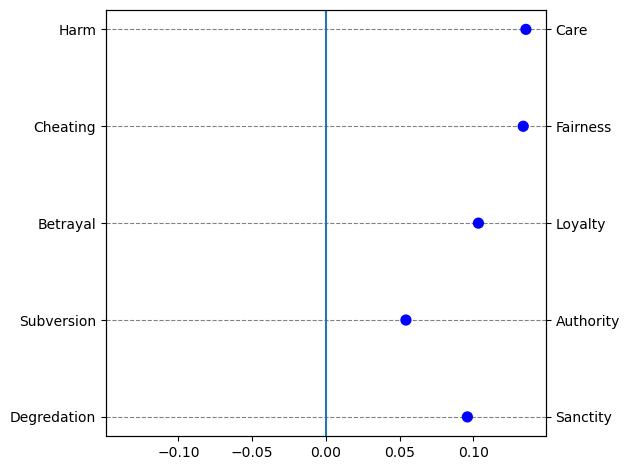

In [4]:
care_df = pd.DataFrame(care_dims)
g = framing_dimen_model.visualize(care_df)
g.axes[0].set_axisbelow(True)
g.axes[0].yaxis.grid(color="gray", linestyle="dashed")

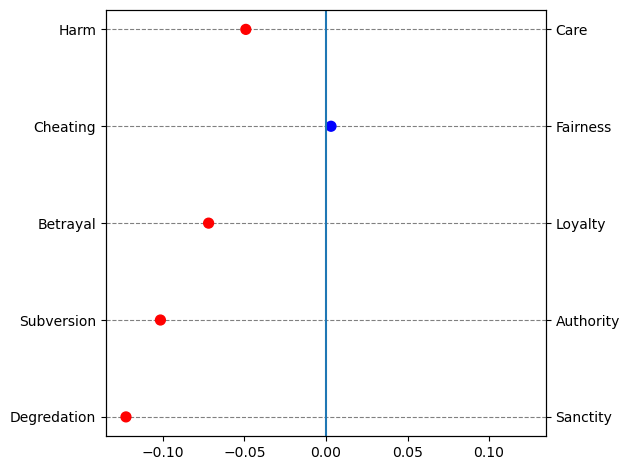

In [5]:
harm_df = pd.DataFrame(harm_dims)
g = framing_dimen_model.visualize(harm_df)
g.axes[0].set_axisbelow(True)
g.axes[0].yaxis.grid(color="gray", linestyle="dashed")